# Irrelevant Features

Thomas Breuel

In [2]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")
import seaborn as sns

import torch
from torchmore import flex
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import linalg as LA

device = "cuda:0" if torch.cuda.is_available() else "cpu"

from tutlib.pcaica import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
train_ds = list(datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor()))
images = np.concatenate([x[0].view(1, -1).numpy() for x in train_ds], axis=0)
classes = np.array([x[1] for x in train_ds])
cuimages = torch.stack([x[0].view(-1) for x in train_ds]).to(device)
print(images.shape, cuimages.shape)

(60000, 784) torch.Size([60000, 784])


In [ ]:
def train_batch(model, opt, xs, target):
    opt.zero_grad()
    xs = xs.view(xs.shape[0], -1).to(device)
    y = model(xs)
    loss = F.cross_entropy(y, target.to(device))
    loss.backward()
    opt.step()
    err = (y.argmax(dim=1) != target.to(device)).float().mean()
    return float(loss), float(err)

In [ ]:
def train_mnist(model, train_ds=train_ds, nepochs=50, batch_size=256, lr=0.3):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    print(next(iter(train_dl))[0].shape)
    opt = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(nepochs+1):
        log = []
        for xs, cs in train_dl:
            loss, err = train_batch(model, opt, xs, cs)
            log.append((loss, err))
        loss, err = np.mean(log, axis=0)
        if epoch % 10 == 0:
            print(f"{epoch:2d} loss {loss:.3f} err {err:.3f}")

# Irrelevant Features

Unsupervised: identify signal/noise by Gaussianity, magnitude.

Supervised: identify signal/noise from backpropagated deltas?


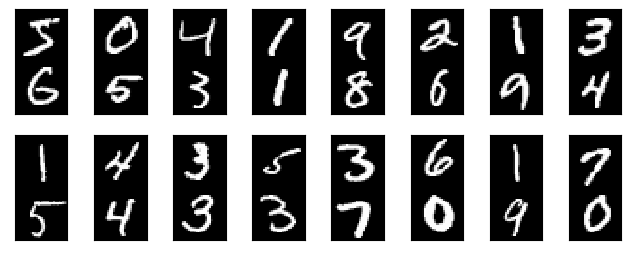

In [ ]:
# Generate data with "noise": top half of image is relevant, bottom is not.

perm = list(range(60000))
random.shuffle(perm)
pairs = hstack([images, images[perm,:]]).reshape(60000, 56*28)
pair_ds = [(pairs[i], classes[i]) for i in range(60000)]
bottom_ds = [(images[i], classes[perm[i]]) for i in range(60000)]
figsize(8, 3)
showgrid(pairs.reshape(-1, 56, 28), rows=2, cols=8)

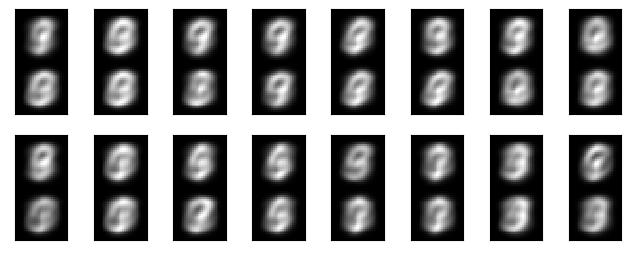

In [ ]:
# PCA mixes up top and bottom characters because it tries to find an optimal code in the L2 sense

k = 100
pca = decomposition.PCA(k)
pca.fit(pairs.reshape(len(pairs), -1))
pca_basis = pca.inverse_transform(diag(ones(k))).reshape(k, 56, 28)
figsize(8, 3)
showgrid(pca_basis, rows=2, cols=8)

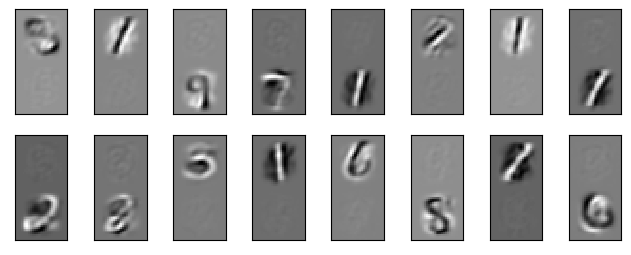

In [ ]:
# ICA recognizes the top and bottom components as "independent causes"
# and represents them as separate dimensions in ICA space, but can't determine relevance.

k = 100
ica = decomposition.FastICA(k, whiten="arbitrary-variance")
ica.fit(pairs.reshape(len(pairs), -1))
ica_basis = ica.inverse_transform(diag(ones(k))).reshape(k, 56, 28)
figsize(8, 3)
showgrid(ica_basis, rows=2, cols=8)

In [ ]:
# train a network to perform classification

def make_pair_model():
    return nn.Sequential(nn.Linear(56*28, 100), nn.ReLU(), nn.Linear(100, 10)).to(device)

pnn100 = make_pair_model()
train_mnist(pnn100, pair_ds, nepochs=50)

torch.Size([256, 1568])
 0 loss 0.551 err 0.165
10 loss 0.062 err 0.017
20 loss 0.021 err 0.003
30 loss 0.009 err 0.000
40 loss 0.005 err 0.000
50 loss 0.003 err 0.000


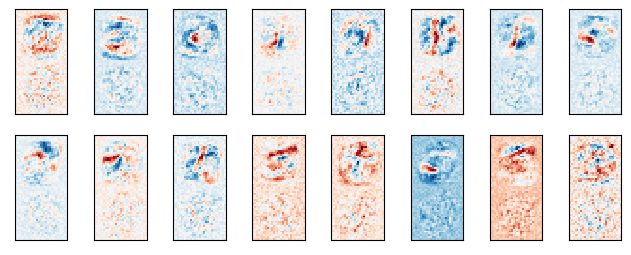

In [ ]:
# display weights; note substantial non-zero weights in bottom half

W = N(pnn100[0].weight)
showgrid(W.reshape(100, 56, 28), cmap=cm.RdBu, rows=2, cols=8)

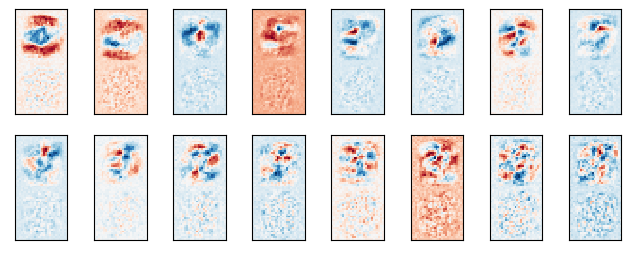

In [ ]:
# weights are much larger at the top than at the bottom

pca = decomposition.PCA(20)
pca.fit(W.reshape(len(W), -1))
showgrid(pca.components_.reshape(-1, 56, 28), cmap=cm.RdBu, rows=2, cols=8)

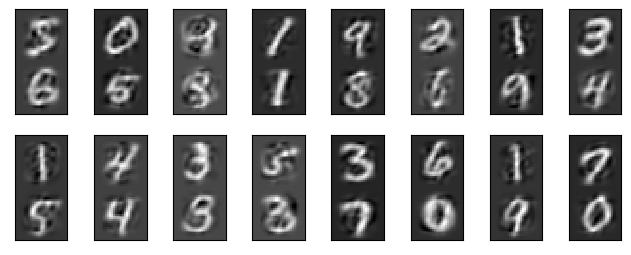

In [ ]:
# nevertheless, we can still reconstruct the full inputs from the linear subspace
cupairs = torch.tensor(pairs).to(device)
pnn100first_layer = N(pnn100[0](cupairs))
pnn100recon = dot(pnn100first_layer, dot(pinv(pnn100first_layer), pairs))
showgrid(pnn100recon.reshape(-1, 56, 28), rows=2, cols=8)

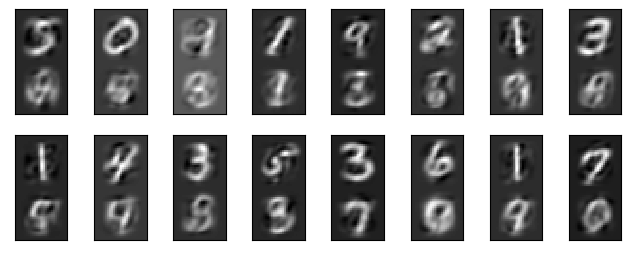

In [ ]:
# reconstruction is more difficult after the nonlinear layer, but it is still possible
pnn100nl= N(pnn100[:2](cupairs))
pnn100nlrecon = dot(pnn100nl, dot(pinv(pnn100nl), pairs))
showgrid(pnn100nlrecon.reshape(-1, 56, 28), rows=2, cols=8)

In [ ]:
pnn100

Sequential(
  (0): Linear(in_features=1568, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

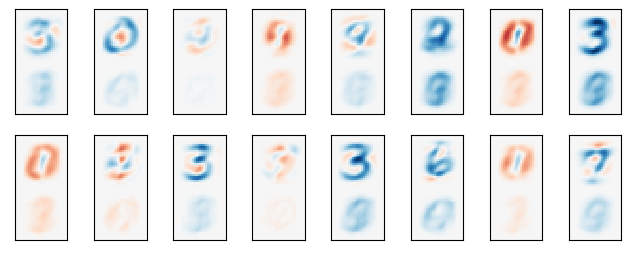

In [ ]:
# reconstruction is more difficult after the nonlinear layer, but it is still possible
pnn100full = N(pnn100(cupairs))
pnn100fullrecon = dot(pnn100full, dot(pinv(pnn100full), pairs))
showgrid(pnn100fullrecon.reshape(-1, 56, 28), rows=2, cols=8, vmin=-1, vmax=1, cmap=cm.RdBu)

# Deeper Models

In [ ]:
def make_deep_model():
    return nn.Sequential(
        nn.Linear(56*28, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)

deep = make_deep_model()
train_mnist(deep, pair_ds, nepochs=50)
deep.eval();

torch.Size([256, 1568])
 0 loss 0.286 err 0.084
10 loss 0.010 err 0.003
20 loss 0.001 err 0.000
30 loss 0.000 err 0.000
40 loss 0.000 err 0.000
50 loss 0.000 err 0.000


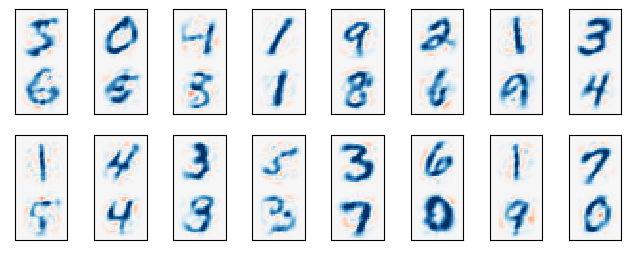

In [ ]:
# reconstruction is more difficult after the nonlinear layer, but it is still possible
deepfeatures = N(deep[:1](cupairs))
deeprecon = dot(deepfeatures, dot(pinv(deepfeatures), pairs))
showgrid(deeprecon.reshape(-1, 56, 28), rows=2, cols=8, vmin=-1, vmax=1, cmap=cm.RdBu)

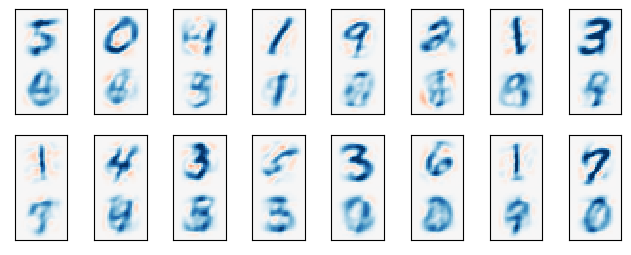

In [ ]:
# reconstruction is more difficult after the nonlinear layer, but it is still possible
deepfeatures = N(deep[:3](cupairs))
deeprecon = dot(deepfeatures, dot(pinv(deepfeatures), pairs))
showgrid(deeprecon.reshape(-1, 56, 28), rows=2, cols=8, vmin=-1, vmax=1, cmap=cm.RdBu)

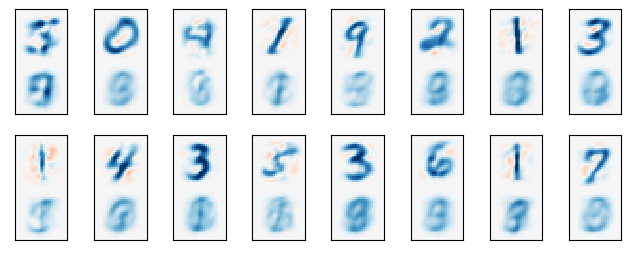

In [ ]:
# reconstruction is more difficult after the nonlinear layer, but it is still possible
deepfeatures = N(deep[:-1](cupairs))
deeprecon = dot(deepfeatures, dot(pinv(deepfeatures), pairs))
showgrid(deeprecon.reshape(-1, 56, 28), rows=2, cols=8, vmin=-1, vmax=1, cmap=cm.RdBu)

# SUMMARY

Linear layers tend to have large weights for relevant features, small weights for irrelevant features.

We can use simple linear models to reconstruct inputs from hidden activations.

Irrelevant information is gradually lost in deeper networks.

# Summary

## Summary (Observations)

For fully connected layers with logistic hidden units:
- linear layers are often PCA-like
- information is destroyed in the non-linear layer

## Summary (Techniques)

We have seen a number of useful experiments/tools:

- PCA, ICA, RICA, pseudo-inverse
- use measures of non-Gaussianity to determine whether layers aim for complete representation, non-Gaussianity, sparsity
- grafting together different networks
- techniques can be generalized by replacing linear methods with DNNs (at the cost of optimality)